Code by: **Fiona Chow and Jennah Gosciak**
* We are auditing the ADS with a public GitHub repo is here: https://github.com/jennahgosciak/algaebloom
* The original GitHub repository associated with this competition is here: https://github.com/apwheele/algaebloom

**Install and Load Libraries/Files**

In [172]:
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [173]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
os.getcwd()
#os.chdir('/Users/fionachow/algaebloom')
os.chdir('C:/Users/Jennah/Desktop/Code/rds_project/algaebloom')
import geopandas as gpd
from census import Census
from us import states
import numpy as np
from tabulate import tabulate

In [37]:
satellite_data = pd.read_csv('./data/sat.csv')
elevation_data = pd.read_csv('./data/elevation_dem.csv')
metadata = pd.read_csv('./data/metadata.csv')

train = pd.read_csv('./data/train_labels.csv')
test = pd.read_csv('./data/test_labels.csv')
algae_acs = pd.read_csv('./data/algae_pts_with_tracts.csv')
spat_lag = pd.read_csv('./data/spat_lag.csv')
split_pred = pd.read_csv('./data/split_pred.csv')
submission_fmt = pd.read_csv('./data/submission_format.csv')

In [174]:
train.shape

(3000, 4)

# Code for Input/Output Section
* Includes EDA on all input datasets and code for generating figures

**EDA for Metadata**

In [7]:
#count of training labels
train_count = metadata[metadata['split'] == 'train']['split'].value_counts()
#count of test labels
test_count = metadata[metadata['split'] == 'test']['split'].value_counts()

print(train_count)
print("----------")
print(test_count)

train    3000
Name: split, dtype: int64
----------
test    1167
Name: split, dtype: int64


In [8]:
#metadata types
metadata_train = metadata.loc[metadata['split']=='train']
metadata_train.dtypes

uid           object
latitude     float64
longitude    float64
date          object
split         object
dtype: object

C:\Users\Jennah\AppData\Local\Temp\ipykernel_25216\516329874.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_train['date_fmt'] = pd.to_datetime(metadata_train['date'])


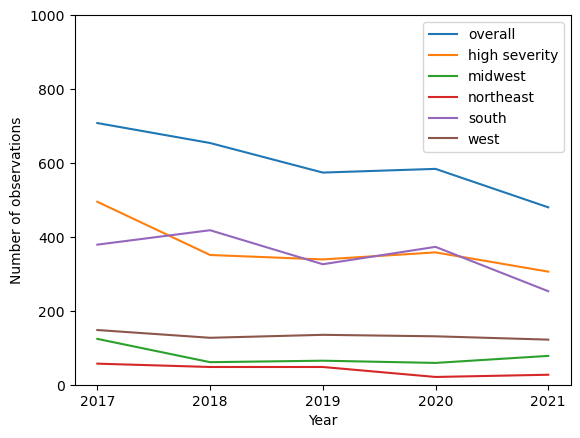

In [14]:
#Figure 1: Number of training data observations by year

train['severity_bin'] = np.where(train['density'] >= 20000, 'high', 'low')
metadata_train['date_fmt'] = pd.to_datetime(metadata_train['date'])
metadata_train_plot_df = pd.merge(train, metadata_train, on = "uid")
train['severity_bin'].value_counts(normalize=True)
metadata_train_plot_df['region'].unique()

metadata_train_plot_df['date_fmt'].dt.year.value_counts().sort_index().plot(
    rot=45, label = 'overall'
)
metadata_train_plot_df.loc[metadata_train_plot_df['severity_bin'] == 'high',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'high severity'
)
metadata_train_plot_df.loc[metadata_train_plot_df['region'] == 'midwest',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'midwest'
)
metadata_train_plot_df.loc[metadata_train_plot_df['region'] == 'northeast',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'northeast'
)
metadata_train_plot_df.loc[metadata_train_plot_df['region'] == 'south',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'south'
)
metadata_train_plot_df.loc[metadata_train_plot_df['region'] == 'west',
                           'date_fmt'].dt.year.value_counts().sort_index().plot(
    label = 'west'
)
plt.ylim(0,1000)
plt.xticks(list(range(2017,2022)))
plt.ylabel('Number of observations')
plt.xlabel('Year')
plt.legend()
plt.savefig('./plots/timeseries_year.pdf')

**EDA for Training Data**

Notes from DrivenData:
* severity (int): severity level based on the cyanobacteria density
* density (float): raw measurement of total cyanobacteria density in cells per mL. Participants should submit predictions for severity level, NOT for the raw cell density value in cells per milliliter (mL). See the Submission format section.


Train columns: ['uid' 'region' 'severity' 'density' 'severity_bin']


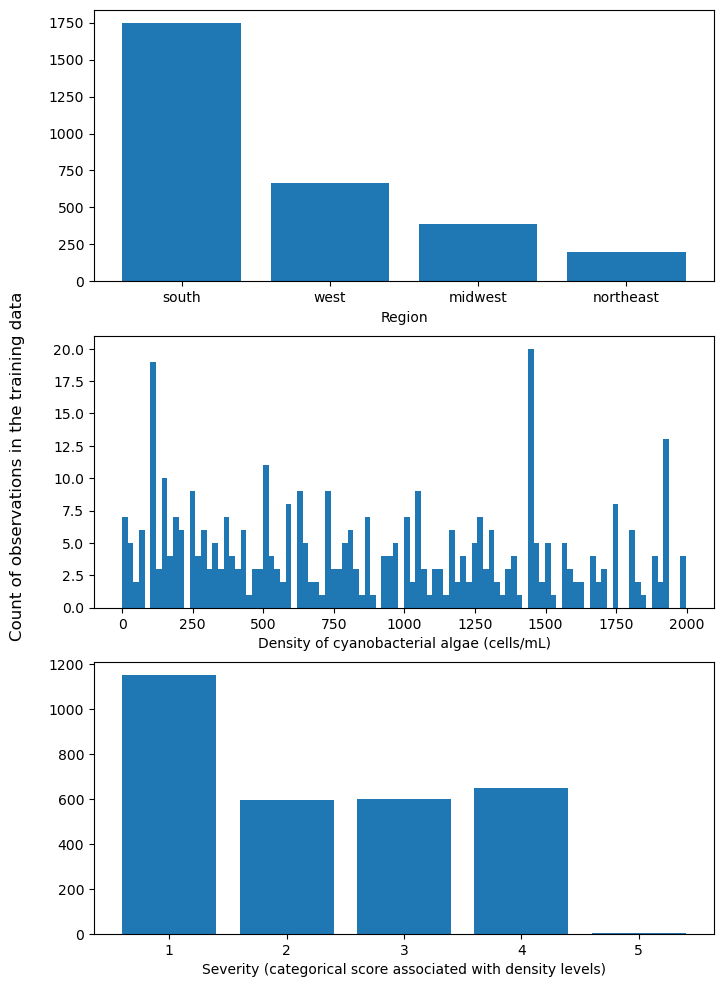

In [27]:
#Figure 2: Value distributions of input features from training labels
print("Train columns:", train.columns.values)
fig, axs = plt.subplots(3,1, figsize=(8,12))
axs[0].bar(train['region'].value_counts().index,
           train['region'].value_counts())
axs[2].bar(train['severity'].value_counts().index,
            train['severity'].value_counts())
axs[1].hist(train.loc[train['density'] < 2000, 'density'], bins=100)
axs[0].set_xlabel('Region')
axs[2].set_xlabel('Severity (categorical score associated with density levels)')
axs[1].set_xlabel('Density of cyanobacterial algae (cells/mL)')
fig.supylabel('Count of observations in the training data')
plt.savefig('./plots/train_labels_hist.pdf')

In [65]:
#training data types
train.dtypes

uid              object
region           object
severity          int64
density         float64
severity_bin     object
dtype: object

In [34]:
round(train['severity'].value_counts(normalize=True),2)

1    0.38
4    0.22
3    0.20
2    0.20
5    0.00
Name: severity, dtype: float64

**EDA for Elevation Data**

In [28]:
#elevation data types
elevation_filt = elevation_data.loc[elevation_data['uid'].isin(train['uid'])]
elevation_filt.dtypes

latitude     float64
longitude    float64
box            int64
elevation    float64
mine         float64
maxe         float64
dife         float64
avge         float64
stde         float64
uid           object
DateTime      object
dtype: object

In [176]:
elevation_filt.shape

(3000, 11)

In [29]:
#elevation data info
elevation_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23570 entries, 0 to 23569
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   23570 non-null  float64
 1   longitude  23570 non-null  float64
 2   box        23570 non-null  int64  
 3   elevation  23570 non-null  float64
 4   mine       23570 non-null  float64
 5   maxe       23570 non-null  float64
 6   dife       23570 non-null  float64
 7   avge       23570 non-null  float64
 8   stde       23570 non-null  float64
 9   uid        23570 non-null  object 
 10  DateTime   23570 non-null  object 
dtypes: float64(8), int64(1), object(2)
memory usage: 2.0+ MB


In [30]:
#finding missing values by filtering for -99999 values as he documented using dife = -99999 for missing elevation data
elevation_data_describe = elevation_data[elevation_data['dife']== -99999].any(axis=1)

elevation_data_describe.describe()

count       0
unique      0
top       NaN
freq      NaN
dtype: object

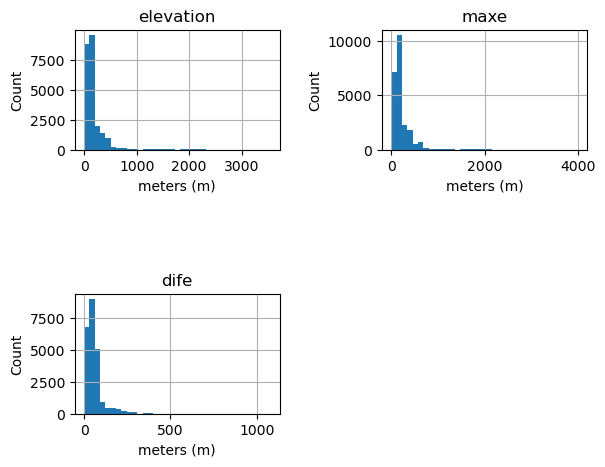

In [32]:
#Figure 3 - Plotting value distributions of input features for elevation data

elevation_data_input_features = elevation_data.drop(columns=['latitude', 'longitude', 'box', 'avge', 'stde', 'mine'])
hist_info = elevation_data_input_features.hist(bins=35)

plt.xlim(0, 1000)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=1.2)

# Iterate through the axes and set labels
for ax in hist_info.flatten():
    ax.set_ylabel('Count')
    ax.set_xlabel('meters (m)')

#plt.show()
plt.savefig('./plots/elevation_features_value_distributions.pdf')

In [70]:
#elevation data statistics
elevation_data.describe()

,latitude,longitude,box,elevation,mine,maxe,dife,avge,stde
count,23570.000000,23570.000000,23570.0,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000,23570.000000
mean,37.599112,-91.438307,1000.0,175.416188,159.612456,218.089806,58.477350,182.174718,11.890973
std,2.823860,17.886877,0.0,273.668598,269.082678,296.131317,55.980386,278.927905,13.567918
min,26.389430,-124.179200,1000.0,-6.573961,-8.489909,0.000000,0.000000,-5.039981,0.000000
25%,35.700925,-109.370945,1000.0,56.113747,45.532188,97.374672,23.930344,65.147533,4.125027
50%,36.228150,-79.268000,1000.0,124.059055,98.498672,162.546829,51.229195,127.206436,9.250443
75%,38.930270,-79.026108,1000.0,180.500000,173.500000,229.550110,68.817337,184.266804,13.593365
max,48.973250,-67.698650,1000.0,3547.000000,3365.940430,3988.470703,1078.071045,3618.695068,213.942810


/var/folders/hb/l21bg8lx3tgc5ky3s56cwdth0000gn/T/ipykernel_13992/2425464916.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  elevation_correlation = elevation_data_input_features.corr()


<Axes: >

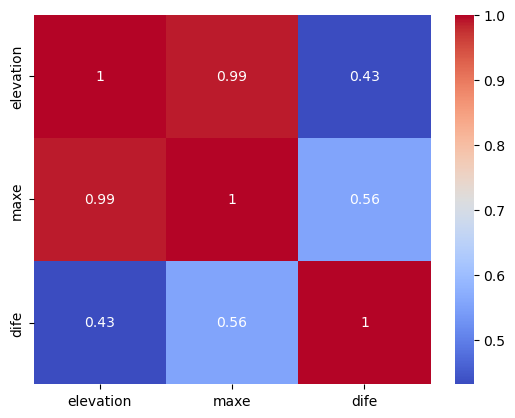

In [71]:
#Figure 4 - Elevation data correlation
elevation_correlation = elevation_data_input_features.corr()
sns.heatmap(elevation_correlation,annot=True, cmap='coolwarm')

**EDA for Satellite Data**

In [72]:
#satellite data statistics
satellite_filt = satellite_data.loc[satellite_data['uid'].isin(train['uid']) | 
                                    satellite_data['uid'].isin(test['uid'])]
satellite_filt.describe()

,prop_lake_500,r_500,g_500,b_500,prop_lake_1000,r_1000,g_1000,b_1000,prop_lake_2500,r_2500,g_2500,b_2500
count,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000,2409.000000
mean,0.290154,127.809781,116.501116,89.103550,0.278580,131.758920,118.601446,90.949455,0.268171,134.995212,120.171041,92.775850
std,0.188427,56.016938,47.162234,46.319377,0.184434,52.330402,44.421790,44.563824,0.166606,48.764293,41.803439,43.317639
min,0.001456,1.000000,1.000000,1.000000,0.000335,1.000000,1.000000,1.000000,0.000248,1.000000,1.000000,1.000000
25%,0.137808,84.031873,82.032649,55.944079,0.139839,88.680403,86.802002,59.398676,0.138985,95.530093,91.051068,62.976869
50%,0.255161,124.516930,113.030488,83.103250,0.236383,132.596494,116.474663,84.968225,0.240796,136.472131,117.962559,86.438008
75%,0.414082,169.916667,142.700000,108.095238,0.387603,172.130292,144.000402,110.294123,0.374461,171.179788,143.244822,109.397648
max,1.000000,255.000000,255.000000,255.000000,1.000000,255.000000,255.000000,255.000000,1.000000,255.000000,247.808472,255.000000


In [73]:
#satellite data types and data info
satellite_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353 entries, 0 to 9352
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   imtype          9353 non-null   object 
 1   prop_lake_500   9353 non-null   float64
 2   r_500           9353 non-null   float64
 3   g_500           9353 non-null   float64
 4   b_500           9353 non-null   float64
 5   prop_lake_1000  9353 non-null   float64
 6   r_1000          9353 non-null   float64
 7   g_1000          9353 non-null   float64
 8   b_1000          9353 non-null   float64
 9   prop_lake_2500  9353 non-null   float64
 10  r_2500          9353 non-null   float64
 11  g_2500          9353 non-null   float64
 12  b_2500          9353 non-null   float64
 13  uid             9353 non-null   object 
 14  DateTime        9353 non-null   object 
dtypes: float64(12), object(3)
memory usage: 1.1+ MB


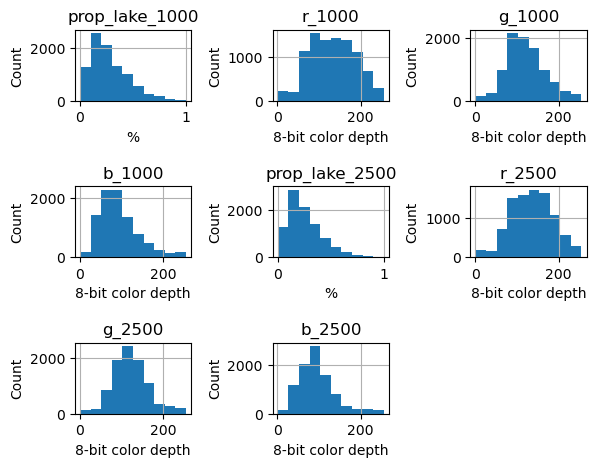

In [74]:
#Figure 5 - Plotting value distributions of input features for satellite data
satellite_data_input_features = satellite_data.drop(columns = ['prop_lake_500','r_500','g_500','b_500'])
numerical_columns_df = satellite_data_input_features.select_dtypes(include=['number'])
hist_info = numerical_columns_df.hist()
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.7, hspace=1.2)

 # Iterate through the axes and set labels
for ax, col in zip(hist_info.flatten(), numerical_columns_df.columns):
    ax.set_ylabel('Count')
    if col in ['prop_lake_1000', 'prop_lake_2500']:
        ax.set_xlabel('%')
    else:
        ax.set_xlabel('8-bit color depth')

In [75]:
#finding missing values by filtering for -1 values as he documented using .fillna(-1) for missing satelite data
satellite_data[(satellite_data==-1).any(axis=1)]

,imtype,prop_lake_500,r_500,g_500,b_500,prop_lake_1000,r_1000,g_1000,b_1000,prop_lake_2500,r_2500,g_2500,b_2500,uid,DateTime


/var/folders/hb/l21bg8lx3tgc5ky3s56cwdth0000gn/T/ipykernel_13992/1807249570.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sat_correlation = satellite_data_input_features.corr()


<Axes: >

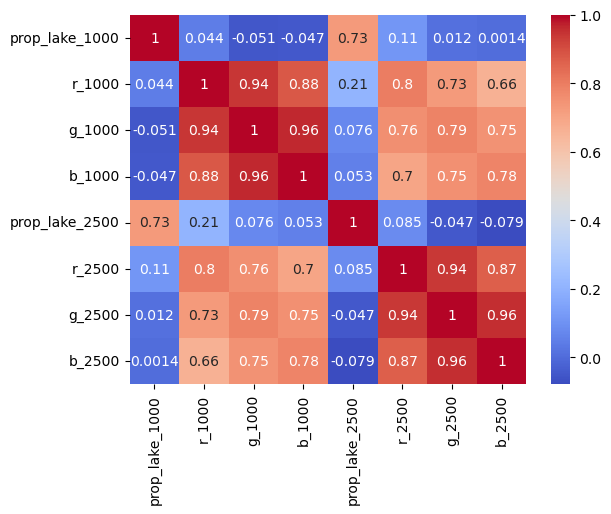

In [76]:
#Figure 6: Correlation of input features from satellite images
sat_correlation = satellite_data_input_features.corr()
sns.heatmap(sat_correlation, annot=True, cmap='coolwarm')

**EDA for Output Data**

**Important note from DrivenData:** "Each geographic area is either entirely in the train set or entirely in the test set. This means that none of the test set locations are in the training data, so your model's performance will be measured on unseen locations."

What should we consider to be severe?
* From this [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4014740/#:~:text=In%20particular%2C%20Cyanobacteria%20may%20be,water%20and%20decreases%20its%20transparency): "At times, the phenomenon is so obvious, that the naked eye can see the mass of microscopic algae, which produce blooms giving a particular coloring to the water body. The term “algal blooms” indicates a situation in which 80%–90% of the mass of microscopic algae consists of one or two species. In particular, Cyanobacteria may be considered as blooming when their cell number exceeds one million per liter. This coating of microscopic algae covers the surface of the water and decreases its transparency. This, in turn, prevents the penetration of sunlight, something that, coupled with the thermal stratification typical of reservoirs in the Mediterranean area, inevitably engenders conditions of anoxia and, hence, the above-mentioned consequence"
* Some background from this [article](https://www.nature.com/articles/s41598-019-54453-y): "Cyanobacterial harmful algal blooms (cyanoHABs) are a serious environmental, water quality and public health issue worldwide because of their ability to form dense biomass and scum and to produce toxins such as neurotoxins (anatoxin-a), hepatotoxins (microcystins), and cytotoxins (cylindrospermospin)1. Cyanotoxins are capable of causing a wide variety of adverse human health issues including gastrointestinal distress, dermatitis, liver failure, or even death of domestic and livestock animals when they are exposed to water with toxins from intense cyanoHABs2,3. CyanoHABs are considered to be increasing globally over the past few decades although observations are quite limited4,5. The frequency and magnitude of these blooms are expected to worsen in the future with increased surface water temperatures and vertical stratification6. In addition, cyanoHAB growth and intensity are known to be affected by weather-driven environmental and anthropogenic factors, such as shifts in rainfall patterns with climatology and changing agricultural practices."
    * "Based on the [World Health Organization’s (WHO)](https://www.who.int/publications/m/item/toxic-cyanobacteria-in-water---second-edition) cell abundance threshold, three magnitude classes were considered for categorizing lakes as Low (≤20,000 cells mL−1), Moderate (20,000 ≤ cells mL−1 ≤ 100,000), and High (>100,000 cells mL−1) exposure health risk"

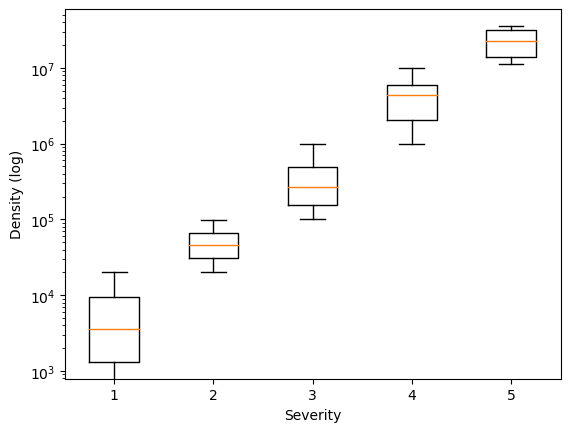

In [77]:
#Figure 7: Range of density values for each severity level
plt.boxplot([train.loc[train['severity']==x,'density'] for x in range(1,6)])
plt.yscale('log')
plt.xticks(rotation=0)
plt.ylabel('Density (log)')
plt.xlabel('Severity')
plt.show();

In [78]:
#density distribution
print("severity over 1,000,000:", np.mean(train['density'] > 1000000))
print("severity over 100,000:", np.mean(train['density'] > 100000))
print("severity over 20,000:", np.mean(train['density'] > 20000))

severity over 1,000,000: 0.21733333333333332
severity over 100,000: 0.41733333333333333
severity over 20,000: 0.6163333333333333


In [79]:
#classifying densities into high/low severities
train['severity_bin'] = np.where(train['density'] >= 20000, 'high', 'low')
train['severity_bin'].value_counts(normalize=True)



high    0.616333
low     0.383667
Name: severity_bin, dtype: float64

In [80]:
#proportion of severity bins with severity levels
train[['severity_bin','severity']].value_counts(normalize=True)

severity_bin  severity
low           1           0.383667
high          4           0.216000
              3           0.200333
              2           0.198667
              5           0.001333
dtype: float64

In [81]:
#covert to latex
train[['severity_bin','severity']].value_counts(normalize=True).reset_index().style.to_latex()

'\\begin{tabular}{llrr}\n & severity_bin & severity & 0 \\\\\n0 & low & 1 & 0.383667 \\\\\n1 & high & 4 & 0.216000 \\\\\n2 & high & 3 & 0.200333 \\\\\n3 & high & 2 & 0.198667 \\\\\n4 & high & 5 & 0.001333 \\\\\n\\end{tabular}\n'

In [82]:
#distribution of severity bins per region
mgd_severity_counts = pd.merge(train[['region', 'severity_bin']].value_counts().reset_index(drop=False).sort_values(['region', 'severity_bin']).rename({0:'count'}, axis=1),
         train['region'].value_counts().reset_index(drop=False).rename({'region':'total', 'index':'region'},axis=1),
         on='region')
mgd_severity_counts['pct'] = mgd_severity_counts['count']/mgd_severity_counts['total']
mgd_severity_counts['pct_total'] = mgd_severity_counts['count']/sum(mgd_severity_counts['total'])
mgd_severity_counts


,region,severity_bin,count,total,pct,pct_total
0,midwest,high,315,387,0.813953,0.052500
1,midwest,low,72,387,0.186047,0.012000
2,northeast,high,116,201,0.577114,0.019333
3,northeast,low,85,201,0.422886,0.014167
4,south,high,762,1749,0.435678,0.127000
5,south,low,987,1749,0.564322,0.164500
6,west,high,656,663,0.989442,0.109333
7,west,low,7,663,0.010558,0.001167


## Downloading Census Data

In [181]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from census import Census
from us import states
import os
import numpy as np
import config

In [182]:
c = Census(config.census_api)
# c = Census(api_key)
states

<module 'us.states' from 'c:\\Users\\Jennah\\anaconda3\\envs\\bloom\\lib\\site-packages\\us\\states.py'>

In [183]:
state_codes = {
    'WA': '53', 'DE': '10', 'DC': '11', 'WI': '55', 'WV': '54', 'HI': '15',
    'FL': '12', 'WY': '56', 'PR': '72', 'NJ': '34', 'NM': '35', 'TX': '48',
    'LA': '22', 'NC': '37', 'ND': '38', 'NE': '31', 'TN': '47', 'NY': '36',
    'PA': '42', 'AK': '02', 'NV': '32', 'NH': '33', 'VA': '51', 'CO': '08',
    'CA': '06', 'AL': '01', 'AR': '05', 'VT': '50', 'IL': '17', 'GA': '13',
    'IN': '18', 'IA': '19', 'MA': '25', 'AZ': '04', 'ID': '16', 'CT': '09',
    'ME': '23', 'MD': '24', 'OK': '40', 'OH': '39', 'UT': '49', 'MO': '29',
    'MN': '27', 'MI': '26', 'RI': '44', 'KS': '20', 'MT': '30', 'MS': '28',
    'SC': '45', 'KY': '21', 'OR': '41', 'SD': '46'
}

In [186]:
census_dfs = []
for i in state_codes:
    census_dfs.append(c.acs5.state_county_tract(fields = 
                                                ('NAME', 'B19019_001E', 'B19113_001E',
                                                          'B02001_001E', 'B16009_002E', 'B01003_001E', 'B02001_002E', 'B02001_003E',
                                                          'B02001_003E', 'B02001_005E', 'B03001_003E', 'B02001_004E', 'B02001_006E',
                                                          'B02001_007E', 'B02001_008E'),
                                      state_fips = state_codes[i],
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2019))

In [187]:
census_df = pd.concat([pd.DataFrame(x) for x in census_dfs], axis=0).rename({'B19019_001E': 'median_household_income',
                                                                             'B19113_001E': 'median_family_income',
                                                                             'B02001_001E': 'total_pop_race',
                                                                             'B16009_002E': 'poverty',
                                                                             'B01003_001E': 'total_pop',
                                                                             'B02001_002E': 'white',
                                                                             'B02001_003E': 'black',
                                                                             'B02001_005E': 'asian',
                                                                             'B02001_004E': 'aian',
                                                                             'B02001_006E': 'nhpi',
                                                                             'B02001_007E': 'other',
                                                                             'B02001_008E': 'multi',
                                                                             'B03001_003E': 'hispanic_latino'
                                                                             }, axis=1)
census_df

,NAME,median_household_income,median_family_income,total_pop_race,poverty,total_pop,white,black,asian,hispanic_latino,aian,nhpi,other,multi,state,county,tract
0,"Census Tract 416, Clark County, Washington",37083.0,50326.0,3486.0,606.0,3486.0,2282.0,351.0,80.0,1033.0,15.0,185.0,399.0,174.0,53,011,041600
1,"Census Tract 430, Clark County, Washington",61771.0,62969.0,1993.0,164.0,1993.0,1706.0,41.0,96.0,444.0,0.0,12.0,66.0,72.0,53,011,043000
2,"Census Tract 408.05, Clark County, Washington",98911.0,104000.0,6981.0,510.0,6981.0,6362.0,48.0,224.0,300.0,16.0,132.0,15.0,184.0,53,011,040805
3,"Census Tract 404.03, Clark County, Washington",92546.0,101750.0,4204.0,292.0,4204.0,3967.0,115.0,63.0,174.0,5.0,0.0,24.0,30.0,53,011,040403
4,"Census Tract 406.04, Clark County, Washington",88561.0,89848.0,5810.0,301.0,5810.0,4852.0,79.0,253.0,651.0,14.0,0.0,119.0,493.0,53,011,040604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,"Census Tract 9659, Clay County, South Dakota",32385.0,65192.0,6131.0,1592.0,6131.0,5223.0,221.0,205.0,239.0,152.0,0.0,97.0,233.0,46,027,965900
218,"Census Tract 9543.01, Codington County, South ...",40701.0,66458.0,4577.0,882.0,4577.0,4226.0,43.0,45.0,71.0,147.0,14.0,0.0,102.0,46,029,954301
219,"Census Tract 9543.02, Codington County, South ...",79727.0,84488.0,5098.0,189.0,5098.0,4914.0,127.0,34.0,34.0,13.0,0.0,0.0,10.0,46,029,954302
220,"Census Tract 9545.01, Codington County, South ...",49348.0,64625.0,2492.0,433.0,2492.0,2243.0,8.0,7.0,130.0,146.0,0.0,2.0,86.0,46,029,954501


In [191]:
census_dfs_state = []
for i in state_codes:
    census_dfs_state.append(c.acs5.state(fields = ('NAME', 'B19019_001E', 'B19113_001E',
                                                          'B02001_001E', 'B16009_002E', 'B01003_001E', 'B02001_002E', 'B02001_003E',
                                                          'B02001_003E', 'B02001_005E', 'B03001_003E', 'B02001_004E', 'B02001_006E',
                                                          'B02001_007E', 'B02001_008E'),
                                      state_fips = state_codes[i],
                                      year = 2019))

In [192]:
census_df_state = pd.concat([pd.DataFrame(x) for x in census_dfs_state], axis=0).rename({'B19019_001E': 'median_household_income_state_overall',
                                                                             'B19113_001E': 'median_family_income_state_overall',
                                                                             'B02001_001E': 'total_pop_race_state_overall',
                                                                             'B16009_002E': 'poverty_state_overall',
                                                                             'B01003_001E': 'total_pop_state_overall',
                                                                             'B02001_002E': 'white_state_overall',
                                                                             'B02001_003E': 'black_state_overall',
                                                                             'B02001_005E': 'asian_state_overall',
                                                                             'B02001_004E': 'aian_state_overall',
                                                                             'B02001_006E': 'nhpi_state_overall',
                                                                             'B02001_007E': 'other_state_overall',
                                                                             'B02001_008E': 'multi_state_overall',
                                                                             'B03001_003E': 'hispanic_latino_state_overall'
                                                                             }, axis=1)
census_df_state

,NAME,median_household_income_state_overall,median_family_income_state_overall,total_pop_race_state_overall,poverty_state_overall,total_pop_state_overall,white_state_overall,black_state_overall,asian_state_overall,hispanic_latino_state_overall,aian_state_overall,nhpi_state_overall,other_state_overall,multi_state_overall,state
0,Washington,73775.0,88660.0,7404107.0,721206.0,7404107.0,5581128.0,281683.0,631333.0,937579.0,94449.0,49090.0,333038.0,433386.0,53
0,Delaware,68287.0,83127.0,957248.0,99177.0,957248.0,658237.0,212302.0,37009.0,88364.0,3729.0,542.0,18350.0,27079.0,10
0,District of Columbia,86420.0,113561.0,692683.0,97919.0,692683.0,285857.0,320811.0,27592.0,76191.0,2091.0,376.0,34511.0,21445.0,11
0,Wisconsin,61747.0,78679.0,5790716.0,583941.0,5790716.0,4946961.0,371200.0,161841.0,394392.0,51392.0,2400.0,118350.0,138572.0,55
0,West Virginia,46711.0,59607.0,1817305.0,283127.0,1817305.0,1691600.0,66990.0,14523.0,28368.0,3667.0,419.0,7971.0,32135.0,54
0,Hawaii,81275.0,94982.0,1422094.0,119044.0,1422094.0,354847.0,26025.0,537355.0,149118.0,3710.0,142997.0,17433.0,339727.0,15
0,Florida,55660.0,67414.0,20901636.0,2622303.0,20901636.0,15702256.0,3359031.0,571276.0,5346684.0,59320.0,12653.0,625079.0,572021.0,12
0,Wyoming,64049.0,79782.0,581024.0,56631.0,581024.0,531304.0,5582.0,5025.0,57341.0,14164.0,596.0,8832.0,15521.0,56
0,Puerto Rico,20539.0,24979.0,3318447.0,1358077.0,3318447.0,2188014.0,386676.0,6237.0,3275919.0,6838.0,269.0,554764.0,175649.0,72
0,New Jersey,82545.0,102260.0,8878503.0,789342.0,8878503.0,6018074.0,1194882.0,840168.0,1794736.0,19711.0,3458.0,558665.0,243545.0,34


In [193]:
census_df.shape

(74001, 17)

In [194]:
tract_shape = []
for i in state_codes:
    tract_shape.append(gpd.read_file(f"https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_codes[i]}_tract.zip"))

In [195]:
tract_gdf = pd.concat(tract_shape, axis=0).reset_index()
tract_gdf

,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,0,53,049,950800,53049950800,9508,Census Tract 9508,G5020,S,42157200,107412602,+46.5827228,-124.0272568,"POLYGON ((-124.08567 46.71716, -124.08256 46.7..."
1,1,53,061,051701,53061051701,517.01,Census Tract 517.01,G5020,S,2491298,0,+47.8299704,-122.2999369,"POLYGON ((-122.31500 47.82142, -122.31498 47.8..."
2,2,53,061,051918,53061051918,519.18,Census Tract 519.18,G5020,S,4477551,0,+47.7834467,-122.2143909,"POLYGON ((-122.23305 47.78378, -122.23304 47.7..."
3,3,53,061,052006,53061052006,520.06,Census Tract 520.06,G5020,S,1932452,0,+47.8494718,-122.1963226,"POLYGON ((-122.20972 47.84538, -122.20963 47.8..."
4,4,53,061,052105,53061052105,521.05,Census Tract 521.05,G5020,S,51597252,3007422,+47.8770813,-122.0961284,"POLYGON ((-122.18909 47.92844, -122.18611 47.9..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73996,217,46,081,966301,46081966301,9663.01,Census Tract 9663.01,G5020,S,121953995,301439,+44.5510342,-103.9491554,"POLYGON ((-104.05597 44.56310, -104.05595 44.5..."
73997,218,46,081,966600,46081966600,9666,Census Tract 9666,G5020,S,1080589898,156413,+44.2609032,-103.7870725,"POLYGON ((-104.05563 44.36380, -104.05563 44.3..."
73998,219,46,011,958600,46011958600,9586,Census Tract 9586,G5020,S,933997276,6323802,+44.3767751,-096.5957541,"POLYGON ((-96.75838 44.19721, -96.75739 44.207..."
73999,220,46,011,959000,46011959000,9590,Census Tract 9590,G5020,S,12725733,216908,+44.2768342,-096.7748038,"POLYGON ((-96.78859 44.30193, -96.78858 44.302..."


In [196]:
# create geodataframe
algae_gdf = gpd.GeoDataFrame(
    metadata, geometry=gpd.points_from_xy(metadata['longitude'], metadata['latitude'], crs=4326)).to_crs(4269)
algae_gdf

,uid,latitude,longitude,date,split,geometry
0,aabm,39.080319,-86.430867,2018-05-14,train,POINT (-86.43087 39.08032)
1,aafp,35.647742,-79.271782,2017-11-15,train,POINT (-79.27178 35.64774)
2,aagm,35.906885,-79.132962,2020-06-10,train,POINT (-79.13296 35.90689)
3,aaia,35.980000,-78.791686,2018-06-27,train,POINT (-78.79169 35.98000)
4,aaql,38.691000,-100.924000,2018-08-13,train,POINT (-100.92400 38.69100)
...,...,...,...,...,...,...
4162,zzkp,42.238550,-111.853100,2017-07-18,test,POINT (-111.85310 42.23855)
4163,zzpz,35.726309,-79.125853,2019-07-17,train,POINT (-79.12585 35.72631)
4164,zzqy,37.928600,-121.561000,2018-05-15,test,POINT (-121.56100 37.92860)
4165,zzry,38.256057,-86.776403,2021-07-19,train,POINT (-86.77640 38.25606)


In [197]:
algae_mgd = algae_gdf.sjoin(tract_gdf, how="left")

In [202]:
# check total missing values (to fix later)
algae_mgd['GEOID'].isna().sum()

42

In [203]:
def calculate_nearest_tract(row, tracts):
    """Calculate distance to nearest tract using the argmin distance"""
    print(row)
    distances = tracts.distance(row)
    return tracts.iloc[np.argmin(distances)]['GEOID']
tract_gdf_proj = tract_gdf.to_crs(3857)
# for those that are missing as a result of the spatial join, calculate GEOID with the smallest (argmin) distance
min_dist_geoid = algae_mgd.to_crs(3857).loc[algae_mgd['GEOID'].isna()]['geometry'].apply(lambda x: calculate_nearest_tract(x, tract_gdf_proj))
min_dist_geoid

POINT (-8803145.331932073 5390947.425112973)
POINT (-8803145.331932073 5390947.425112973)
POINT (-9141185.556080813 5480930.477499096)
POINT (-8833572.622309074 5388900.785383256)
POINT (-8833572.622309074 5388900.785383256)
POINT (-8833572.622309074 5388900.785383256)
POINT (-9128198.245048434 5383275.239233437)
POINT (-9178477.585496558 5665446.269644195)
POINT (-9128198.245048434 5383275.239233437)
POINT (-9178477.585496558 5665446.269644195)
POINT (-8833572.622309074 5388900.785383256)
POINT (-9128198.245048434 5383275.239233437)
POINT (-8803145.331932073 5390947.425112973)
POINT (-8803145.331932073 5390947.425112973)
POINT (-9141185.556080813 5480930.477499096)
POINT (-9134506.386633215 5448435.180076642)
POINT (-8772161.44410111 5403236.157915665)
POINT (-9178477.585496558 5665446.269644195)
POINT (-9141185.556080813 5480930.477499096)
POINT (-9128198.245048434 5383275.239233437)
POINT (-9134506.386633215 5448435.180076642)
POINT (-9178477.585496558 5665446.269644195)
POINT (-914

165     36063990000
221     36063990000
418     26063990000
506     36063990000
510     36063990000
681     36063990000
738     26151990000
766     26141990000
804     26151990000
941     26141990000
1081    36063990000
1603    26151990000
1625    36063990000
1655    36063990000
1712    26063990000
1767    26063990000
2021    36063990000
2111    26141990000
2152    26063990000
2177    26151990000
2221    26063990000
2222    26141990000
2294    26063990000
2353    26063990000
2360    26151990000
2413    26141990000
2447    26063990000
2480    36063990000
2521    36063990000
2719    26063990000
2953    36063990000
3059    26063990000
3068    36063990000
3096    36063990000
3136    26141990000
3346    26151990000
3445    36063990000
3447    36063990000
3490    26063990000
3625    36063990000
3757    26063990000
3971    36063990000
Name: geometry, dtype: object

In [204]:
min_dist_geoid.to_csv("./data/min_dist_geoid.csv")

In [205]:
# replace missing values with distances
min_dist_geoid= pd.read_csv("./data/min_dist_geoid.csv")
algae_mgd.loc[algae_mgd['GEOID'].isna(), "GEOID"] = min_dist_geoid['geometry']

In [206]:
algae_mgd["GEOID"].isna().sum()
print(len(min_dist_geoid))

42


In [207]:
tract_subset = tract_gdf.loc[tract_gdf["GEOID"].isin(algae_mgd["GEOID"])]
tract_subset.head()

,index,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
1364,1364,53,053,072603,53053072603,726.03,Census Tract 726.03,G5020,S,91149394,108018989,+47.2094984,-122.6842971,"POLYGON ((-122.85192 47.25195, -122.84568 47.2..."
1406,1406,53,007,960400,53007960400,9604,Census Tract 9604,G5020,S,136924635,19187501,+47.9336076,-120.1068123,"POLYGON ((-120.20768 47.90775, -120.20744 47.9..."
1459,1,10,005,051007,10005051007,510.07,Census Tract 510.07,G5020,S,10284652,4825988,+38.6944980,-075.1130691,"POLYGON ((-75.13420 38.70986, -75.13420 38.709..."
1468,10,10,005,051306,10005051306,513.06,Census Tract 513.06,G5020,S,11824795,2881389,+38.4787667,-075.1012742,"POLYGON ((-75.14047 38.47760, -75.14046 38.477..."
1469,11,10,005,050703,10005050703,507.03,Census Tract 507.03,G5020,S,13377962,3392136,+38.5953496,-075.2311317,"POLYGON ((-75.29127 38.59603, -75.29126 38.596..."


<Axes: >

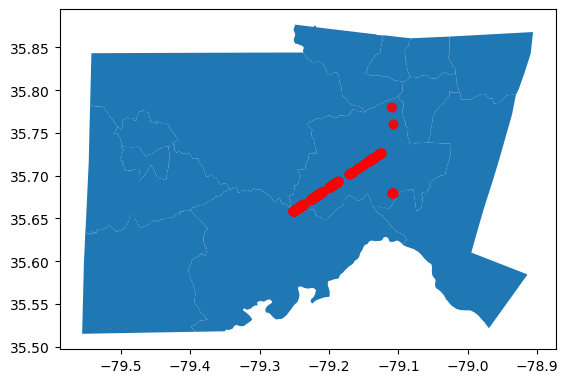

In [208]:
#checking an outlier case
fig, ax = plt.subplots(1, 1)
tract_gdf.loc[(tract_gdf['STATEFP']=='37') & (tract_gdf['COUNTYFP']=='037')].plot(ax=ax)
algae_mgd.loc[algae_mgd['GEOID']=='37037020800'].plot(ax=ax, color='red', alpha=0.5)

In [209]:
# merge to census data
census_df['GEOID'] = census_df['state'] + \
    census_df['county'].str.pad(3, side = 'left', fillchar = '0') + \
    census_df['tract'].str.pad(6, side = 'left', fillchar = '0')
algae_mgd_census = pd.merge(algae_mgd, census_df, on = "GEOID", how = "left")
algae_mgd_census.head()

,uid,latitude,longitude,date,split,geometry,index_right,index,STATEFP,COUNTYFP,...,black,asian,hispanic_latino,aian,nhpi,other,multi,state,county,tract
0,aabm,39.080319,-86.430867,2018-05-14,train,POINT (-86.43087 39.08032),51336.0,923.0,18,105,...,32.0,31.0,81.0,28.0,0.0,93.0,194.0,18,105,001402
1,aafp,35.647742,-79.271782,2017-11-15,train,POINT (-79.27178 35.64774),19434.0,1091.0,37,037,...,869.0,134.0,303.0,0.0,0.0,1.0,66.0,37,037,020600
2,aagm,35.906885,-79.132962,2020-06-10,train,POINT (-79.13296 35.90689),18723.0,380.0,37,135,...,540.0,16.0,217.0,24.0,0.0,80.0,58.0,37,135,010701
3,aaia,35.980000,-78.791686,2018-06-27,train,POINT (-78.79169 35.98000),18997.0,654.0,37,063,...,3741.0,0.0,738.0,15.0,0.0,416.0,326.0,37,063,001806
4,aaql,38.691000,-100.924000,2018-08-13,train,POINT (-100.92400 38.69100),69349.0,327.0,20,171,...,0.0,61.0,766.0,4.0,3.0,145.0,70.0,20,171,957100


In [218]:
algae_mgd_census['poverty_rate'] = algae_mgd_census['poverty'] / algae_mgd_census['total_pop']
algae_mgd_census['percent_white'] = algae_mgd_census['white'] / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_black'] = algae_mgd_census['black'] / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_asian'] = algae_mgd_census['asian'] / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_aian'] = algae_mgd_census['aian'] / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_nhpi'] = algae_mgd_census['nhpi'] / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_other'] = algae_mgd_census['other'] / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_multi'] = algae_mgd_census['multi'] / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_nonwhite'] = (algae_mgd_census['total_pop_race'] - algae_mgd_census['white']) / algae_mgd_census['total_pop_race']
algae_mgd_census['percent_hispanic_latino'] = algae_mgd_census['hispanic_latino'] / algae_mgd_census['total_pop_race']

In [219]:
algae_mgd_census.loc[algae_mgd_census['poverty_rate'].isna(), 'total_pop'].isna().sum()

42

In [226]:
# create variable constructs
constructs = ['poverty_rate', 'percent_white', 'percent_black', 'percent_asian', 'percent_aian',
              'percent_nhpi', 'percent_other', 'percent_multi', 'percent_hispanic_latino', 'percent_nonwhite']
census_df['poverty_rate'] = census_df['poverty'] / census_df['total_pop']
census_df['percent_white'] = census_df['white'] / census_df['total_pop_race']
census_df['percent_black'] = census_df['black'] / census_df['total_pop_race']
census_df['percent_asian'] = census_df['asian'] / census_df['total_pop_race']
census_df['percent_aian'] = census_df['aian'] / census_df['total_pop_race']
census_df['percent_nhpi'] = census_df['nhpi'] / census_df['total_pop_race']
census_df['percent_other'] = census_df['other'] / census_df['total_pop_race']
census_df['percent_multi'] = census_df['multi'] / census_df['total_pop_race']
census_df['percent_nonwhite'] = (census_df['total_pop_race'] - census_df['white']) / census_df['total_pop_race']
census_df['percent_hispanic_latino'] = census_df['hispanic_latino'] / census_df['total_pop_race']

census_state_summ = census_df.groupby('state', as_index = False)[constructs].mean()
census_state_summ.columns = ['state'] + [i + "_state" for i in constructs]
census_state_summ

,state,poverty_rate_state,percent_white_state,percent_black_state,percent_asian_state,percent_aian_state,percent_nhpi_state,percent_other_state,percent_multi_state,percent_hispanic_latino_state,percent_nonwhite_state
0,01,0.168345,0.629139,0.321788,0.011160,0.005198,0.000437,0.013980,0.018299,0.040617,0.370861
1,02,0.098187,0.628716,0.028743,0.057760,0.176982,0.010639,0.013750,0.083409,0.063468,0.371284
2,04,0.139709,0.774349,0.042313,0.032215,0.050463,0.001946,0.062523,0.036191,0.305316,0.225651
3,05,0.159840,0.734703,0.192895,0.012426,0.006492,0.001904,0.024562,0.027019,0.066940,0.265297
4,06,0.122364,0.604868,0.058291,0.138479,0.008366,0.003744,0.137897,0.048356,0.380866,0.395132
5,08,0.098256,0.847247,0.037534,0.029517,0.011028,0.001461,0.037664,0.035551,0.213503,0.152753
6,09,0.095963,0.750618,0.114815,0.042953,0.002944,0.000333,0.054399,0.033940,0.169997,0.249382
7,10,0.111348,0.691152,0.223111,0.035074,0.003992,0.000502,0.019975,0.026193,0.092316,0.308848
8,11,0.146126,0.398569,0.485316,0.036713,0.003073,0.000657,0.045537,0.030135,0.102797,0.601431
9,12,0.130531,0.762284,0.156440,0.024428,0.002877,0.000609,0.027717,0.025643,0.233372,0.237716


In [227]:
algae_mgd_state = pd.merge(algae_mgd_census, census_state_summ, on = 'state', how = 'left')
algae_mgd_state = pd.merge(algae_mgd_state, census_df_state, on = 'state', how = 'left')
# missing values are a population total = 0
algae_mgd_state.head()

,uid,latitude,longitude,date,split,geometry,index_right,index,STATEFP,COUNTYFP,...,poverty_state_overall,total_pop_state_overall,white_state_overall,black_state_overall,asian_state_overall,hispanic_latino_state_overall,aian_state_overall,nhpi_state_overall,other_state_overall,multi_state_overall
0,aabm,39.080319,-86.430867,2018-05-14,train,POINT (-86.43087 39.08032),51336.0,923.0,18,105,...,782759.0,6665703.0,5553391.0,626587.0,151979.0,461850.0,15782.0,2506.0,145747.0,169711.0
1,aafp,35.647742,-79.271782,2017-11-15,train,POINT (-79.27178 35.64774),19434.0,1091.0,37,037,...,1325875.0,10264876.0,7049919.0,2200761.0,292992.0,962665.0,123952.0,7213.0,316763.0,273276.0
2,aagm,35.906885,-79.132962,2020-06-10,train,POINT (-79.13296 35.90689),18723.0,380.0,37,135,...,1325875.0,10264876.0,7049919.0,2200761.0,292992.0,962665.0,123952.0,7213.0,316763.0,273276.0
3,aaia,35.980000,-78.791686,2018-06-27,train,POINT (-78.79169 35.98000),18997.0,654.0,37,063,...,1325875.0,10264876.0,7049919.0,2200761.0,292992.0,962665.0,123952.0,7213.0,316763.0,273276.0
4,aaql,38.691000,-100.924000,2018-08-13,train,POINT (-100.92400 38.69100),69349.0,327.0,20,171,...,305642.0,2910652.0,2455935.0,170291.0,85794.0,345680.0,24010.0,2382.0,71683.0,100557.0


In [228]:
# create binary categories
algae_mgd_bin = algae_mgd_state
for i in constructs:
    algae_mgd_bin[i + "_bin"] = np.select([algae_mgd_bin[i] > algae_mgd_bin[i + "_state"],
                                           algae_mgd_bin[i] <= algae_mgd_bin[i + "_state"],
                                            algae_mgd_bin[i].isna()],
                                          [1, 0, 0])
    print(f"\n checking values for {i}")
    print(algae_mgd_bin[i + "_bin"].value_counts(normalize=True).sort_index())
algae_mgd_bin['missing_pop'] = np.where(algae_mgd_bin['total_pop'] == 0 | algae_mgd_bin['total_pop'].isna(), 1, 0)


 checking values for poverty_rate
0    0.803456
1    0.196544
Name: poverty_rate_bin, dtype: float64

 checking values for percent_white
0    0.170146
1    0.829854
Name: percent_white_bin, dtype: float64

 checking values for percent_black
0    0.893928
1    0.106072
Name: percent_black_bin, dtype: float64

 checking values for percent_asian
0    0.841373
1    0.158627
Name: percent_asian_bin, dtype: float64

 checking values for percent_aian
0    0.832253
1    0.167747
Name: percent_aian_bin, dtype: float64

 checking values for percent_nhpi
0    0.87113
1    0.12887
Name: percent_nhpi_bin, dtype: float64

 checking values for percent_other
0    0.798176
1    0.201824
Name: percent_other_bin, dtype: float64

 checking values for percent_multi
0    0.742021
1    0.257979
Name: percent_multi_bin, dtype: float64

 checking values for percent_hispanic_latino
0    0.728582
1    0.271418
Name: percent_hispanic_latino_bin, dtype: float64

 checking values for percent_nonwhite
0    0.861531

In [229]:
algae_mgd_bin['low_income'] = np.where((algae_mgd_bin['poverty_rate'] >= 0.2) | (algae_mgd_bin['median_family_income'] <= algae_mgd_bin['median_family_income_state_overall']), 1, 0)

In [230]:
algae_mgd_bin.to_csv("./data/algae_pts_with_tracts.csv")

## Code for hyperparameter tuning
* Note: most of this code is copied from the original [GitHub repository](https://github.com/apwheele/algaebloom), as we downsample the data.

In [150]:
from src import feat, mod
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime

today = feat.today_str()

In [151]:
#added main_prepdata.py which generates the database 
import pandas as pd
import sqlite3

db = './data/data.sqlite'
tab_names = ['elevation_dem','split_pred','spat_lag','sat']
meta_names = ['meta','labels', 'format']
meta_csv = ['metadata','train_labels','submission_format']

fd = {c:t for c,t in zip(meta_csv,meta_names)}
ft = {t:t for t in tab_names}
fd.update(ft)

# Function to save out csv files
def save_csv(db=db):
    db_con = sqlite3.connect(db)
    for t in tab_names:
        res = pd.read_sql(f'SELECT * FROM {t}',db_con)
        res.to_csv(f'./data/{t}.csv',index=False)

# Function to prep SQLite DB
def prep_sql(db=db):
    db_con = sqlite3.connect(db)
    for csv,tab_name in fd.items():
        res = pd.read_csv(f'./data/{csv}.csv')
        res.to_sql(tab_name,index=False,if_exists='replace',con=db_con)
    # Showing resulting table names
    query = "SELECT name FROM sqlite_master WHERE type='table';"
    rt = pd.read_sql(query,db_con)
    print('Resulting table names in sqlite')
    print(rt['name'].tolist())

if __name__ == "__main__":
    print('Executing script to prep data in sqlite')
    print('This expects the csv files listed at front')
    print('of script to be in the data folder')
    prep_sql()


Executing script to prep data in sqlite
This expects the csv files listed at front
of script to be in the data folder
Resulting table names in sqlite
['test_labels', 'meta', 'labels', 'format', 'elevation_dem', 'split_pred', 'spat_lag', 'sat']


### Tuning
* Sub-sampling 3,000 rows from the original training dataset, filtered for year > 2016
* Using 500 rows as the test dataset
* All code comes from the original repository with slight modifications

In [152]:
import optuna
from src import feat, mod

res_results = {}

train_dat = feat.get_data(split_pred=True)
print(train_dat.shape)

(3000, 38)


In [153]:
# need to add for testing purposes
print(test.shape)
# feat.add_table(test, 'test_labels', db)

(1167, 39)


In [154]:
# Model fit with weights
weight_cats = tuple([False])

# Model fit with categorical variables
cat_cats = (True,False)

# Lat/Lon included in model
xy_cats = {'no': [],
           'both': ['latitude','longitude'],
           'lat': ['latitude'],
           'lon': ['longitude']}

xy_keys = tuple(xy_cats.keys())

# Region variables
region_cats = {'both': ['region','cluster'],
               'reg':  ['region'],
               'clust':  ['cluster']}

reg_keys = tuple(region_cats.keys())

# Elevation Variables
ele_cats = {'max_dif':['maxe','dife'],
            'all_var':['maxe','dife','elevation','stde'],
            'ele_std':['elevation','stde'],
            'ele_dif':['elevation','dife'],
            'max_std':['maxe','stde'] }

ele_keys = tuple(ele_cats.keys())

In [155]:
# Spatial Lag Variables
sl_cats = {#'lag100': ['severity_100','logDensity_100','count_100'],
           #'lag300': ['severity_300','logDensity_300','count_300'],
           #'lag1000': ['severity_1000','logDensity_1000','count_1000'],
           'lagNone': []}

sl_keys = tuple(sl_cats.keys())

# Sat imagery data
sat_cats = {'sat500': ['imtype','prop_lake_500','r_500','g_500','b_500'],
            'sat1000': ['imtype','prop_lake_1000','r_1000','g_1000','b_1000'],
            'sat2500': ['imtype','prop_lake_2500','r_2500','g_2500','b_2500'],
            'sat500_1000': ['imtype','prop_lake_500','r_500','g_500','b_500', 'prop_lake_1000','r_1000','g_1000','b_1000'],
            'sat500_2500': ['imtype','prop_lake_500','r_500','g_500','b_500', 'prop_lake_2500','r_2500','g_2500','b_2500'],
            'sat1000_2500': ['imtype','prop_lake_1000','r_1000','g_1000','b_1000', 'prop_lake_2500','r_2500','g_2500','b_2500']}

sat_keys = tuple(sat_cats.keys())


In [12]:
def objective_lgb(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 600, 10),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "ele_set": trial.suggest_categorical("ele_vars", ele_keys),
        "xy_set": trial.suggest_categorical("xy_set", xy_keys),
        "sl_set": trial.suggest_categorical("sl_set", sl_keys),
        "reg_set": trial.suggest_categorical("reg_set", reg_keys),
        "weight": trial.suggest_categorical("weight", weight_cats),
        "cat_type": trial.suggest_categorical("cat_type", cat_cats),
        "sat_set": trial.suggest_categorical("sat_set", sat_keys),
    }
    # Setting the different variables
    ov = region_cats[param['reg_set']]
    #if 'imtype' in sat_cats[param['sat_set']]:
    #    ov.append('imtype')
    cv = ele_cats[param['ele_set']] + xy_cats[param['xy_set']]
    cv += sl_cats[param['sl_set']]
    cv += sat_cats[param['sat_set']]
    rm = mod.RegMod(ord_vars=ov,
                    dum_vars=None,
                    dat_vars=['date'],
                    ide_vars=cv,
                    weight = 'split_pred',
                    y='severity',
                    mod = mod.LGBMRegressor(n_estimators=round(param['n_estimators']),
                                            max_depth=param['max_depth']))
    avg_rmse = rm.met_eval(train_dat,ret=True,weight=param['weight'],cat=param['cat_type'])
    return avg_rmse

study_lgb = optuna.create_study(direction="minimize")
study_lgb.optimize(objective_lgb, n_trials=300) # 150
trial_lgb = study_lgb.best_trial
res_results['lgb'] = trial_lgb

[I 2023-04-24 15:33:16,915] A new study created in memory with name: no-name-bfaf5b1c-ac29-41b7-a6de-78bc61afb225
[I 2023-04-24 15:33:17,975] Trial 0 finished with value: 0.8307540464005815 and parameters: {'n_estimators': 130, 'max_depth': 7, 'ele_vars': 'max_std', 'xy_set': 'lat', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'cat_type': False, 'sat_set': 'sat500_2500'}. Best is trial 0 with value: 0.8307540464005815.
[I 2023-04-24 15:33:23,184] Trial 1 finished with value: 0.8801454449119639 and parameters: {'n_estimators': 360, 'max_depth': 10, 'ele_vars': 'max_dif', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'cat_type': True, 'sat_set': 'sat500_2500'}. Best is trial 0 with value: 0.8307540464005815.
[I 2023-04-24 15:33:23,951] Trial 2 finished with value: 0.9701927798346872 and parameters: {'n_estimators': 30, 'max_depth': 2, 'ele_vars': 'ele_dif', 'xy_set': 'no', 'sl_set': 'lagNone', 'reg_set': 'clust', 'weight': False, 'cat_type': False,

In [11]:
def objective_xgb(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 600, 10),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "ele_set": trial.suggest_categorical("ele_vars", ele_keys),
        "xy_set": trial.suggest_categorical("xy_set", xy_keys),
        "sl_set": trial.suggest_categorical("sl_set", sl_keys),
        "reg_set": trial.suggest_categorical("reg_set", reg_keys),
        "weight": trial.suggest_categorical("weight", weight_cats),
        "sat_set": trial.suggest_categorical("sat_set", sat_keys),
    }
    # Setting the different variables
    ov = region_cats[param['reg_set']]
    #if 'imtype' in sat_cats[param['sat_set']]:
    #    ov.append('imtype')
    cv = ele_cats[param['ele_set']] + xy_cats[param['xy_set']]
    cv += sl_cats[param['sl_set']]
    cv += sat_cats[param['sat_set']]
    rm = mod.RegMod(ord_vars=ov,
                    dum_vars=None,
                    dat_vars=['date'],
                    ide_vars=cv,
                    weight = 'split_pred',
                    y='severity',
                    mod = mod.XGBRegressor(n_estimators=round(param['n_estimators']),
                                           max_depth=param['max_depth'])
                )
    avg_rmse = rm.met_eval(train_dat,ret=True,weight=param['weight'])
    return avg_rmse

study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=300)
trial_xgb = study_xgb.best_trial
res_results['xgb'] = trial_xgb

[I 2023-04-25 14:40:58,745] A new study created in memory with name: no-name-79c529d0-2632-4738-aed1-d35a0e6b042e
[I 2023-04-25 14:41:04,497] Trial 0 finished with value: 0.9402009655943425 and parameters: {'n_estimators': 410, 'max_depth': 5, 'ele_vars': 'max_dif', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'sat_set': 'sat500_1000'}. Best is trial 0 with value: 0.9402009655943425.
[I 2023-04-25 14:41:06,218] Trial 1 finished with value: 0.884089008922398 and parameters: {'n_estimators': 60, 'max_depth': 6, 'ele_vars': 'max_dif', 'xy_set': 'lat', 'sl_set': 'lagNone', 'reg_set': 'reg', 'weight': False, 'sat_set': 'sat2500'}. Best is trial 1 with value: 0.884089008922398.
[I 2023-04-25 14:41:14,053] Trial 2 finished with value: 0.9496008659978219 and parameters: {'n_estimators': 560, 'max_depth': 4, 'ele_vars': 'ele_dif', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'sat_set': 'sat1000_2500'}. Best is trial 1 with value: 0.88408

In [9]:
def objective_cat(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 20, 600, 10),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "ele_set": trial.suggest_categorical("ele_vars", ele_keys),
        "xy_set": trial.suggest_categorical("xy_set", xy_keys),
        "sl_set": trial.suggest_categorical("sl_set", sl_keys),
        "reg_set": trial.suggest_categorical("reg_set", reg_keys),
        "weight": trial.suggest_categorical("weight", weight_cats),
        "cat_type": trial.suggest_categorical("cat_type", cat_cats),
        "sat_set": trial.suggest_categorical("sat_set", sat_keys),
    }
    # Setting the different variables
    ov = region_cats[param['reg_set']]
    #if 'imtype' in sat_cats[param['sat_set']]:
    #    ov.append('imtype')
    cv = ele_cats[param['ele_set']] + xy_cats[param['xy_set']]
    cv += sl_cats[param['sl_set']]
    cv += sat_cats[param['sat_set']]
    rm = mod.RegMod(ord_vars=ov,
                    dum_vars=None,
                    dat_vars=['date'],
                    ide_vars=cv,
                    weight = 'split_pred',
                    y='severity',
                    mod = mod.CatBoostRegressor(iterations=round(param['n_estimators']),
                                                depth=param['max_depth'],
                                                allow_writing_files=False,
                                                verbose=False)
                )
    # print(train_dat.shape)
    avg_rmse = rm.met_eval(train_dat,ret=True, weight=param['weight'],cat=param['cat_type'])
    return avg_rmse

study_cat = optuna.create_study(direction="minimize")
study_cat.optimize(objective_cat, n_trials=300, n_jobs=-1)
trial_cat = study_cat.best_trial
res_results['cat'] = trial_cat

[I 2023-04-21 23:53:31,907] A new study created in memory with name: no-name-dca3a0fe-8826-478f-9fe9-ae22cb802f37
[I 2023-04-21 23:53:34,463] Trial 2 finished with value: 0.8875163968633825 and parameters: {'n_estimators': 140, 'max_depth': 2, 'ele_vars': 'all_var', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'cat_type': True, 'sat_set': 'sat1000_2500'}. Best is trial 2 with value: 0.8875163968633825.
[I 2023-04-21 23:53:36,296] Trial 6 finished with value: 0.9108613125253899 and parameters: {'n_estimators': 310, 'max_depth': 3, 'ele_vars': 'max_std', 'xy_set': 'lat', 'sl_set': 'lagNone', 'reg_set': 'reg', 'weight': False, 'cat_type': True, 'sat_set': 'sat1000'}. Best is trial 2 with value: 0.8875163968633825.
[I 2023-04-21 23:53:36,868] Trial 0 finished with value: 0.8231002921406869 and parameters: {'n_estimators': 510, 'max_depth': 3, 'ele_vars': 'max_std', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'cat_type': False, 'sat

In [13]:
print(f"Best Average RMSE LightBoost {trial_lgb.value}")
print("Best Params")
print(trial_lgb.params)

Best Average RMSE LightBoost 0.7889932873562553
Best Params
{'n_estimators': 30, 'max_depth': 4, 'ele_vars': 'max_std', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'reg', 'weight': False, 'cat_type': True, 'sat_set': 'sat500'}


In [12]:
print(f"Best Average RMSE XGBoost {trial_xgb.value}")
print("Best Params")
print(trial_xgb.params)

Best Average RMSE XGBoost 0.8361939088152124
Best Params
{'n_estimators': 270, 'max_depth': 9, 'ele_vars': 'ele_std', 'xy_set': 'both', 'sl_set': 'lagNone', 'reg_set': 'clust', 'weight': False, 'sat_set': 'sat1000'}


In [11]:
print(f"Best Average RMSE CatBoost {trial_cat.value}")
print("Best Params")
print(trial_cat.params)

Best Average RMSE CatBoost 0.8015699072381228
Best Params
{'n_estimators': 420, 'max_depth': 3, 'ele_vars': 'ele_std', 'xy_set': 'lon', 'sl_set': 'lagNone', 'reg_set': 'both', 'weight': False, 'cat_type': False, 'sat_set': 'sat500_2500'}


In [177]:
#main_preds.py
from src import feat, mod

today = feat.today_str()
train_dat = feat.get_data(split_pred=True)
print(train_dat.shape)
###################################
# Example just predicting severity directly

sat_500 = ['prop_lake_500', 'r_500', 'g_500', 'b_500']
sat_1000 = ['prop_lake_1000', 'r_1000', 'g_1000', 'b_1000']
sat_2500 = ['prop_lake_2500', 'r_2500', 'g_2500', 'b_2500']
sat_1025 = ['prop_lake_2500', 'r_2500', 'g_2500', 'b_2500', 
           'prop_lake_1000', 'r_1000', 'g_1000', 'b_1000']

cat = mod.RegMod(ord_vars=region_cats['both'],
                dat_vars=['date'],
                ide_vars=ele_cats['ele_std'] + xy_cats['lon'] + sl_cats['lagNone'] + sat_cats['sat500_2500'],
                y='severity',
                mod = mod.CatBoostRegressor(iterations=420,depth=3,
                   allow_writing_files=False,verbose=False)
                )
cat.fit(train_dat,weight=False,cat=False)


lig = mod.RegMod(ord_vars=region_cats['both'],
                dat_vars=['date'],
                ide_vars=ele_cats['max_std'] + xy_cats['lon'] + sl_cats['lagNone'] + sat_cats['sat500'],
                y='severity',
                mod = mod.LGBMRegressor(n_estimators=30, 
                                        max_depth=4))
lig.fit(train_dat,weight=False,cat=True)


xgb = mod.RegMod(ord_vars=region_cats['clust'],
                 dat_vars=['date'],
                 ide_vars=ele_cats['ele_std'] + xy_cats['both'] + sl_cats['lagNone'] + sat_1000,
                 y='severity',
                 mod = mod.XGBRegressor(n_estimators=270, max_depth=9))
xgb.fit(train_dat,weight=False,cat=False)


rm = mod.EnsMod(mods={'xgb': xgb, 'cat': cat, 'lig': lig})

(3000, 38)


In [157]:
# Now getting files for out of sample data
test = feat.get_data(data_type='test')
print("Rows in test data:", test.shape[0])
test['pred'] = rm.predict_int(test)

form_dat = test.copy()
form_dat['severity'] = form_dat['pred'].round().astype(int).clip(1,5)
print(test['severity'].value_counts())
print(test['pred'].value_counts())

Rows in test data: 1167
1    357
4    336
3    267
2    197
5     10
Name: severity, dtype: int64
2    453
4    298
1    242
3    174
Name: pred, dtype: int64


In [180]:
# brute force, write a function to calcluate the root mean square erorr

## Evaluating performance and fairness

In [159]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

In [160]:
test['severity_bin'] = np.where(test['density'] >= 20_000, 1, 0)
test['pred_bin'] = np.where(test['pred'] >= 2, 1, 0)
print(test['severity_bin'].value_counts(normalize=True))
print(test['pred_bin'].value_counts(normalize=True))

print("\nAccuracy:", accuracy_score(test['severity_bin'], test['pred_bin']))
print("Recall:", recall_score(test['severity_bin'], test['pred_bin']))
print("Precision:", precision_score(test['severity_bin'], test['pred_bin']))

1    0.694087
0    0.305913
Name: severity_bin, dtype: float64
1    0.792631
0    0.207369
Name: pred_bin, dtype: float64

Accuracy: 0.8071979434447301
Recall: 0.9320987654320988
Precision: 0.8162162162162162


In [161]:
# look at confusion matrix
tn, fp, fn, tp = confusion_matrix(test['severity_bin'], test['pred_bin']).ravel()
print("TN:", tn)
print("FP:", fp)
print("FN:", fn)
print("TP:", tp)

TN: 187
FP: 170
FN: 55
TP: 755


In [162]:
%pip install fairlearn
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import sklearn.metrics as skm

from fairlearn.datasets import fetch_adult
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.reductions import ExponentiatedGradient
from fairlearn.reductions import GridSearch
from fairlearn.reductions import DemographicParity, ErrorRate
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.metrics import MetricFrame
from fairlearn.metrics import (selection_rate, demographic_parity_difference, demographic_parity_ratio, 
                               selection_rate_difference, false_negative_rate_difference, 
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

import sklearn.metrics as skm


from IPython.display import clear_output

Note: you may need to restart the kernel to use updated packages.


In [163]:
# load census data
algae_mgd_census = pd.read_csv("./data/algae_pts_with_tracts.csv")
print(algae_mgd_census.columns)
test_census = pd.merge(test, algae_mgd_census, how = 'left', on = 'uid')
missing_values = -9
test_census = test_census.loc[test_census['poverty_rate_bin'] != missing_values]
test_census.head()

Index(['Unnamed: 0', 'uid', 'latitude', 'longitude', 'date', 'split',
       'geometry', 'index_right', 'index', 'STATEFP', 'COUNTYFP', 'TRACTCE',
       'GEOID', 'NAME_x', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER',
       'INTPTLAT', 'INTPTLON', 'NAME_y', 'median_household_income',
       'median_family_income', 'total_pop_race', 'poverty', 'total_pop',
       'white', 'black', 'asian', 'hispanic_latino', 'state', 'county',
       'tract', 'poverty_rate', 'percent_white', 'percent_black',
       'percent_asian', 'percent_nonwhite', 'percent_hispanic_latino',
       'poverty_rate_state', 'percent_white_state', 'percent_black_state',
       'percent_asian_state', 'percent_hispanic_latino_state',
       'percent_nonwhite_state', 'NAME',
       'median_household_income_state_overall',
       'median_family_income_state_overall', 'total_pop_race_state_overall',
       'poverty_state_overall', 'total_pop_state_overall',
       'white_state_overall', 'black_state_overall', 'asian_st

,uid,density,region,severity,latitude_x,longitude_x,date_x,elevation,mine,maxe,...,asian_state_overall,hispanic_latino_state_overall,poverty_rate_bin,percent_white_bin,percent_black_bin,percent_asian_bin,percent_hispanic_latino_bin,percent_nonwhite_bin,missing_pop,low_income
0,aarq,10133.000000,1,1,39.902930,-75.180150,2017-12-05,0.0,-3.707266,36.310219,...,436324.0,935216.0,0,1,0,1,1,0,0,0
1,abjj,55049.333333,1,2,42.056766,-78.879216,2019-09-24,403.5,403.500000,578.112427,...,1647606.0,3720983.0,0,1,0,0,0,0,0,1
2,abrn,7626.284722,1,1,41.890646,-78.925275,2017-10-05,403.0,403.000000,638.767151,...,436324.0,935216.0,1,1,0,0,0,0,0,1
3,actk,1267.000000,1,1,41.894240,-78.938750,2019-04-16,403.0,403.000000,597.634155,...,436324.0,935216.0,1,1,0,0,0,0,0,1
4,adxo,5300.663072,1,1,41.841242,-78.994719,2020-09-02,403.0,403.000000,652.534790,...,436324.0,935216.0,0,1,0,0,0,0,0,1


**Poverty Rate Subpopulation Evaluation**

In [164]:
test_census['poverty_rate_bin'].value_counts()

0    1004
1     163
Name: poverty_rate_bin, dtype: int64

In [165]:
test_census['poverty_rate_bin'].isna().sum()

0

In [166]:
#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(test_census['severity_bin'], test_census['pred_bin'], sensitive_features=test_census['poverty_rate_bin'])
demo_parity_ratio = demographic_parity_ratio(test_census['severity_bin'], test_census['pred_bin'], sensitive_features=test_census['poverty_rate_bin'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

Demographic parity difference: 0.0699
Demographic parity ratio: 0.9180


In [167]:
#compute demographic parity difference and demographic parity ratio
demo_parity_diff = demographic_parity_difference(test_census['severity_bin'], test_census['pred_bin'], sensitive_features=test_census['low_income'])
demo_parity_ratio = demographic_parity_ratio(test_census['severity_bin'], test_census['pred_bin'], sensitive_features=test_census['low_income'])

print(f'Demographic parity difference: {demo_parity_diff:.4f}')
print(f'Demographic parity ratio: {demo_parity_ratio:.4f}')

Demographic parity difference: 0.1311
Demographic parity ratio: 0.8484


In [25]:
#compute selection rate for low and high poverty
high_selection_rate = selection_rate(test_census['severity_bin'][test_census['poverty_rate_bin']==1], test_census['pred_bin'][test_census['poverty_rate_bin']==1])
low_selection_rate = selection_rate(test_census['severity_bin'][test_census['poverty_rate_bin']==0], test_census['pred_bin'][test_census['poverty_rate_bin']==0])

print(f'high selection rate: {high_selection_rate:.4f}')
print(f'low selection rate: {low_selection_rate:.4f}')

high selection rate: 0.8528
low selection rate: 0.7829


In [168]:
#compute selection rate for low and high poverty
high_selection_rate = selection_rate(test_census['severity_bin'][test_census['low_income']==1], test_census['pred_bin'][test_census['low_income']==1])
low_selection_rate = selection_rate(test_census['severity_bin'][test_census['low_income']==0], test_census['pred_bin'][test_census['low_income']==0])

print(f'high selection rate: {high_selection_rate:.4f}')
print(f'low selection rate: {low_selection_rate:.4f}')

high selection rate: 0.8648
low selection rate: 0.7336


In [169]:
def generate_sample_params(sensitive_feat):
  return ({'accuracy': None,
                      'precision': None,
                      'recall': None,
                      'FNR': None,
                      'FPR': None,
                      'FNR_diff': {'sensitive_features' : sensitive_feat},
                      'FPR_diff': {'sensitive_features' : sensitive_feat},
                      'demo_parity_ratio': {'sensitive_features' : sensitive_feat},
                      'equalized_odds_ratio': {'sensitive_features' : sensitive_feat},
                      'sel_rate_diff': {'sensitive_features' : sensitive_feat},})

In [170]:
def generate_metrics(df, sensitive_feature):
    sensitive_feature = df[sensitive_feature].replace({0:'low', 1:'high'})

    #evaluation metrics
    metrics = {'accuracy': skm.accuracy_score,
            'precision': skm.precision_score,
            'recall': skm.recall_score,
            'FNR': false_negative_rate,
            'FPR': false_positive_rate,
            'FNR_diff': false_negative_rate_difference,
            'FPR_diff': false_positive_rate_difference,
            'demo_parity_ratio': demographic_parity_ratio,
            'equalized_odds_ratio': equalized_odds_ratio,
            'sel_rate_diff': selection_rate_difference,
            }

    sample_params_dict = generate_sample_params(sensitive_feature)
    grouped_on_pov = MetricFrame(metrics=metrics,
                                y_true=df['severity_bin'],
                                y_pred=df['pred_bin'],
                                sensitive_features=sensitive_feature,
                                sample_params= sample_params_dict)
    print(grouped_on_pov.overall.to_frame())

    print(grouped_on_pov.by_group)
generate_metrics(test_census, 'poverty_rate_bin')

                             0
accuracy              0.807198
precision             0.816216
recall                0.932099
FNR                   0.067901
FPR                   0.476190
FNR_diff              0.008059
FPR_diff              0.044680
demo_parity_ratio     0.918040
equalized_odds_ratio  0.913618
sel_rate_diff         0.069892
                  accuracy  precision    recall       FNR       FPR  FNR_diff  \
poverty_rate_bin                                                                
high              0.846626   0.892086  0.925373  0.074627  0.517241       0.0   
low               0.800797   0.802799  0.933432  0.066568  0.472561       0.0   

                  FPR_diff  demo_parity_ratio  equalized_odds_ratio  \
poverty_rate_bin                                                      
high                   0.0                1.0                   1.0   
low                    0.0                1.0                   1.0   

                  sel_rate_diff  
poverty_rate_bi

In [171]:
generate_metrics(test_census, 'low_income')

                             0
accuracy              0.807198
precision             0.816216
recall                0.932099
FNR                   0.067901
FPR                   0.476190
FNR_diff              0.060061
FPR_diff              0.116655
demo_parity_ratio     0.848378
equalized_odds_ratio  0.788668
sel_rate_diff         0.131117
            accuracy  precision    recall       FNR       FPR  FNR_diff  \
low_income                                                                
high        0.840000   0.848018  0.962500  0.037500  0.552000       0.0   
low         0.780374   0.785563  0.902439  0.097561  0.435345       0.0   

            FPR_diff  demo_parity_ratio  equalized_odds_ratio  sel_rate_diff  
low_income                                                                    
high             0.0                1.0                   1.0            0.0  
low              0.0                1.0                   1.0            0.0  


**Race and Ethnic Subpopulation Evaluation**

In [130]:
# Race
percent_asian_bin_counts = test_census['percent_asian_bin'].value_counts()
percent_white_bin_counts = test_census['percent_white_bin'].value_counts()
percent_black_bin_counts = test_census['percent_black_bin'].value_counts()
# Ethnicity
percent_hispanic_latino_bin_counts = test_census['percent_hispanic_latino_bin'].value_counts()
# percent_nonwhite_bin_counts = test_census['percent_nonwhite_bin'].value_counts()
# missing_pop_counts = test_census['missing_pop'].value_counts()

print(f'percent_asian_bin_counts...\n{percent_asian_bin_counts}')
print(f'percent_white_bin_counts...\n{percent_white_bin_counts}')
print(f'percent_black_bin_counts...\n{percent_black_bin_counts}')
print(f'percent_hispanic_latino_bin_counts...\n{percent_hispanic_latino_bin_counts}')
# print(f'percent_nonwhite_bin_counts...\n{percent_nonwhite_bin_counts}')
# print(f'missing_pop_counts...\n{missing_pop_counts}')

percent_asian_bin_counts...
0    988
1    179
Name: percent_asian_bin, dtype: int64
percent_white_bin_counts...
1    941
0    226
Name: percent_white_bin, dtype: int64
percent_black_bin_counts...
0    1061
1     106
Name: percent_black_bin, dtype: int64
percent_hispanic_latino_bin_counts...
0    864
1    303
Name: percent_hispanic_latino_bin, dtype: int64
percent_nonwhite_bin_counts...
1    911
0    256
Name: percent_nonwhite_bin, dtype: int64
missing_pop_counts...
0    1132
1      35
Name: missing_pop, dtype: int64


In [140]:
# Check for missing values
asian_na = test_census['percent_asian_bin'].isna().sum()
white_na = test_census['percent_white_bin'].isna().sum()
black_na = test_census['percent_black_bin'].isna().sum()

hispanic_na = test_census['percent_hispanic_latino_bin'].isna().sum()

print(asian_na, white_na, black_na, hispanic_na)

0 0 0 0


In [145]:
# Compute demographic parity difference and demographic parity ratio
demo_parity_diff_asian = demographic_parity_difference(test_census['severity_bin'], test_census['pred_bin'], sensitive_features=test_census['percent_asian_bin'])
demo_parity_ratio_asian = demographic_parity_ratio(test_census['severity_bin'], test_census['pred_bin'], sensitive_features=test_census['percent_asian_bin'])

print(f'Demographic parity (asian) difference: {demo_parity_diff_asian:.4f}')
print(f'Demographic parity (asian) ratio: {demo_parity_ratio_asian:.4f}')

demo_parity_diff_white = demographic_parity_difference(test_census['severity_bin'], test_census['pred_bin'], sensitive_features=test_census['percent_white_bin'])
demo_parity_ratio_white = demographic_parity_ratio(test_census['severity_bin'], test_census['pred_bin'], sensitive_features=test_census['percent_white_bin'])

print(f'Demographic parity (white) difference: {demo_parity_diff_white:.4f}')
print(f'Demographic parity (white) ratio: {demo_parity_ratio_white:.4f}')

demo_parity_diff_black = demographic_parity_difference(test_census['severity_bin'], test_census['pred_bin'], sensitive_features=test_census['percent_black_bin'])
demo_parity_ratio_black = demographic_parity_ratio(test_census['severity_bin'], test_census['pred_bin'], sensitive_features=test_census['percent_black_bin'])

print(f'Demographic parity (black) difference: {demo_parity_diff_black:.4f}')
print(f'Demographic parity (black) ratio: {demo_parity_ratio_black:.4f}')

demo_parity_diff_hispanic_latino = demographic_parity_difference(test_census['severity_bin'], test_census['pred_bin'], sensitive_features=test_census['percent_hispanic_latino_bin'])
demo_parity_ratio_hispanic_latino = demographic_parity_ratio(test_census['severity_bin'], test_census['pred_bin'], sensitive_features=test_census['percent_hispanic_latino_bin'])

print(f'Demographic parity (hispanic_latino) difference: {demo_parity_diff_hispanic_latino:.4f}')
print(f'Demographic parity (hispanic_latino) ratio: {demo_parity_ratio_hispanic_latino:.4f}')

Demographic parity (asian) difference: 0.0140
Demographic parity (asian) ratio: 0.9826
Demographic parity (white) difference: 0.2532
Demographic parity (white) ratio: 0.6992
Demographic parity (black) difference: 0.0728
Demographic parity (black) ratio: 0.9089
Demographic parity (hispanic_latino) difference: 0.1419
Demographic parity (hispanic_latino) ratio: 0.8419


In [149]:
# Compute selection rate for race / ethnicity
high_selection_rate_asian = selection_rate(test_census['severity_bin'][test_census['percent_asian_bin']==1], test_census['pred_bin'][test_census['percent_asian_bin']==1])
low_selection_rate_asian = selection_rate(test_census['severity_bin'][test_census['percent_asian_bin']==0], test_census['pred_bin'][test_census['percent_asian_bin']==0])

print(f'high selection rate (asian): {high_selection_rate_asian:.4f}')
print(f'low selection rate (asian): {low_selection_rate_asian:.4f}')

high_selection_rate_white = selection_rate(test_census['severity_bin'][test_census['percent_white_bin']==1], test_census['pred_bin'][test_census['percent_white_bin']==1])
low_selection_rate_white = selection_rate(test_census['severity_bin'][test_census['percent_white_bin']==0], test_census['pred_bin'][test_census['percent_white_bin']==0])

print(f'high selection rate (white): {high_selection_rate_white:.4f}')
print(f'low selection rate (white): {low_selection_rate_white:.4f}')

high_selection_rate_black = selection_rate(test_census['severity_bin'][test_census['percent_black_bin']==1], test_census['pred_bin'][test_census['percent_black_bin']==1])
low_selection_rate_black = selection_rate(test_census['severity_bin'][test_census['percent_black_bin']==0], test_census['pred_bin'][test_census['percent_black_bin']==0])

print(f'high selection rate (black): {high_selection_rate_black:.4f}')
print(f'low selection rate (black): {low_selection_rate_black:.4f}')

high_selection_rate_hispanic_latino = selection_rate(test_census['severity_bin'][test_census['percent_hispanic_latino_bin']==1], test_census['pred_bin'][test_census['percent_hispanic_latino_bin']==1])
low_selection_rate_hispanic_latino = selection_rate(test_census['severity_bin'][test_census['percent_hispanic_latino_bin']==0], test_census['pred_bin'][test_census['percent_hispanic_latino_bin']==0])

print(f'high selection rate (hispanic_latino): {high_selection_rate_hispanic_latino:.4f}')
print(f'low selection rate (hispanic_latino): {low_selection_rate_hispanic_latino:.4f}')

high selection rate (asian): 0.8045
low selection rate (asian): 0.7905
high selection rate (white): 0.8417
low selection rate (white): 0.5885
high selection rate (black): 0.7264
low selection rate (black): 0.7992
high selection rate (hispanic_latino): 0.8977
low selection rate (hispanic_latino): 0.7558


In [155]:
generate_metrics(test_census, 'percent_asian_bin')

                             0
accuracy              0.807198
precision             0.816216
recall                0.932099
FNR                   0.067901
FPR                   0.476190
FNR_diff              0.026210
FPR_diff              0.122281
demo_parity_ratio     0.982618
equalized_odds_ratio  0.788788
sel_rate_diff         0.013983
                   accuracy  precision    recall       FNR       FPR  \
percent_asian_bin                                                      
high               0.754190   0.770833  0.909836  0.090164  0.578947   
low                0.816802   0.824584  0.936047  0.063953  0.456667   

                   FNR_diff  FPR_diff  demo_parity_ratio  \
percent_asian_bin                                          
high                    0.0       0.0                1.0   
low                     0.0       0.0                1.0   

                   equalized_odds_ratio  sel_rate_diff  
percent_asian_bin                                       
high           

In [156]:
generate_metrics(test_census, 'percent_white_bin')

                             0
accuracy              0.807198
precision             0.816216
recall                0.932099
FNR                   0.067901
FPR                   0.476190
FNR_diff              0.046592
FPR_diff              0.266331
demo_parity_ratio     0.699210
equalized_odds_ratio  0.526087
sel_rate_diff         0.253162
                   accuracy  precision    recall       FNR       FPR  \
percent_white_bin                                                      
high               0.809777   0.828283  0.938484  0.061516  0.561983   
low                0.796460   0.744361  0.891892  0.108108  0.295652   

                   FNR_diff  FPR_diff  demo_parity_ratio  \
percent_white_bin                                          
high                    0.0       0.0                1.0   
low                     0.0       0.0                1.0   

                   equalized_odds_ratio  sel_rate_diff  
percent_white_bin                                       
high           

In [157]:
generate_metrics(test_census, 'percent_black_bin')

                             0
accuracy              0.807198
precision             0.816216
recall                0.932099
FNR                   0.067901
FPR                   0.476190
FNR_diff              0.022198
FPR_diff              0.091157
demo_parity_ratio     0.908875
equalized_odds_ratio  0.812394
sel_rate_diff         0.072831
                   accuracy  precision    recall       FNR       FPR  \
percent_black_bin                                                      
high               0.801887   0.805195  0.911765  0.088235  0.394737   
low                0.807729   0.817217  0.933962  0.066038  0.485893   

                   FNR_diff  FPR_diff  demo_parity_ratio  \
percent_black_bin                                          
high                    0.0       0.0                1.0   
low                     0.0       0.0                1.0   

                   equalized_odds_ratio  sel_rate_diff  
percent_black_bin                                       
high           

In [158]:
generate_metrics(test_census, 'percent_hispanic_latino_bin')

                             0
accuracy              0.807198
precision             0.816216
recall                0.932099
FNR                   0.067901
FPR                   0.476190
FNR_diff              0.065010
FPR_diff              0.009334
demo_parity_ratio     0.841925
equalized_odds_ratio  0.933430
sel_rate_diff         0.141903
                             accuracy  precision    recall       FNR  \
percent_hispanic_latino_bin                                            
high                         0.907591   0.919118  0.976562  0.023438   
low                          0.771991   0.773354  0.911552  0.088448   

                                  FPR  FNR_diff  FPR_diff  demo_parity_ratio  \
percent_hispanic_latino_bin                                                    
high                         0.468085       0.0       0.0                1.0   
low                          0.477419       0.0       0.0                1.0   

                             equalized_odds_ratio

In [160]:
generate_metrics(test_census, 'percent_nonwhite_bin')

                             0
accuracy              0.807198
precision             0.816216
recall                0.932099
FNR                   0.067901
FPR                   0.476190
FNR_diff              0.030932
FPR_diff              0.263355
demo_parity_ratio     0.749913
equalized_odds_ratio  0.531814
sel_rate_diff         0.209733
                      accuracy  precision    recall       FNR       FPR  \
percent_nonwhite_bin                                                      
high                  0.805708   0.823298  0.937407  0.062593  0.562500   
low                   0.812500   0.782609  0.906475  0.093525  0.299145   

                      FNR_diff  FPR_diff  demo_parity_ratio  \
percent_nonwhite_bin                                          
high                       0.0       0.0                1.0   
low                        0.0       0.0                1.0   

                      equalized_odds_ratio  sel_rate_diff  
percent_nonwhite_bin                         